# Model Evaluation

This notebook evaluates the final machine learning model trained to predict NBA All-Star selections based on player and team performance data. 

We will load the saved model and test data, generate predictions, and assess performance using classification metrics and visualizations. Finally, we will analyze feature importance to interpret the factors driving model decisions.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
# load saved model
with open("../models/all_star_model.pkl", "rb") as f:
    model = pickle.load(f)

# load test data
X_test = pd.read_pickle("../data/clean/X_test.pkl")
y_test = pd.read_pickle("../data/clean/y_test.pkl")

# define feature columns
feature_cols = X_test.columns

# if model is logistic regression, load and apply the saved scaler
if isinstance(model, LogisticRegression):
    with open("../models/logreg_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    X_test = scaler.transform(X_test)

In [3]:
# make predictions
y_pred = model.predict(X_test)

# print classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3811
           1       0.78      0.66      0.71       240

    accuracy                           0.97      4051
   macro avg       0.88      0.83      0.85      4051
weighted avg       0.97      0.97      0.97      4051



The detailed metrics above give a numeric summary of model performance. Next, we’ll visualize these results to better understand how the model performs across different classes.

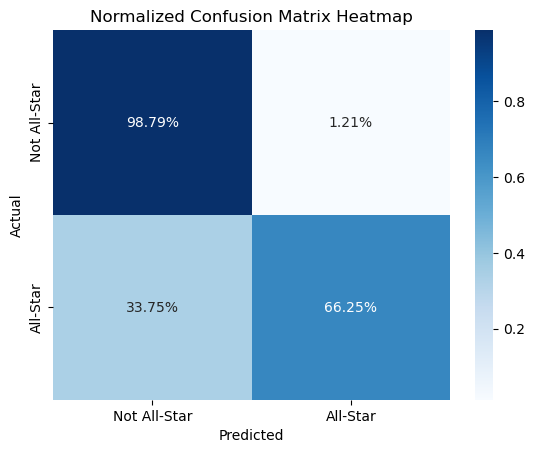

In [4]:
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=["Not All-Star", "All-Star"],
            yticklabels=["Not All-Star", "All-Star"])
plt.title("Normalized Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The normalized confusion matrix shows the model’s performance broken down by actual class.
- The model correctly identifies 96.79% of players who were not All-Stars, demonstrating strong specificity and a low false positive rate (1.21%).
- For actual All-Stars, the model correctly predicts 66.25% of them, reflecting moderate recall. However, it misses about 33.75% of All-Stars, indicating some false negatives.

This means the model is very effective at ruling out non-All-Stars but less effective at capturing every deserving All-Star. The tradeoff between precision and recall is typical in imbalanced classification problems like this. These results highlight the model’s ability to support the project goal of identifying standout players based on performance data, though there remains room to improve recall to capture more true All-Stars.

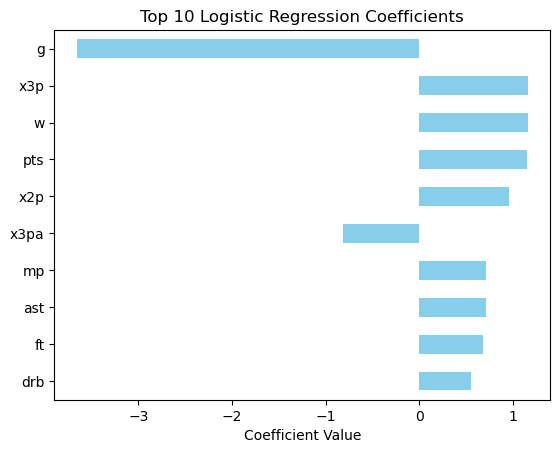

In [5]:
coef = pd.Series(model.coef_[0], index=feature_cols)
coef = coef.sort_values(key=abs, ascending=False).head(10)
coef.plot(kind='barh', color='skyblue')
plt.title("Top 10 Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.show()

Interestingly, the games played feature (`g`) has a strong negative coefficient, which is counterintuitive. While we might expect players who appear in more games to be more likely All-Stars, this may reflect multicollinearity with minutes or points, or patterns where role players log full seasons without standout impact. Let's do a quick check for multicollinearity. 

In [9]:
X = pd.read_pickle("../data/clean/X_data.pkl")
X.corr()["g"].abs().drop("g").sort_values(ascending=False).head(10)

mp      0.851296
pts     0.708104
stl     0.695784
x2pa    0.691663
x2p     0.682324
drb     0.677131
fta     0.621412
ft      0.606752
orb     0.600048
ast     0.558904
Name: g, dtype: float64

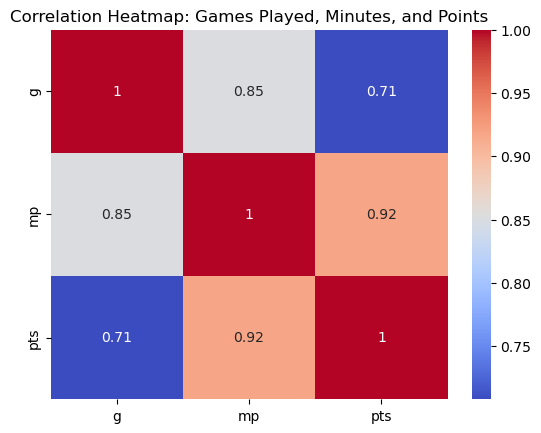

In [12]:
sns.heatmap(X[["g", "mp", "pts"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap: Games Played, Minutes, and Points")
plt.show()

`g` is highly correlated with other features (chiefly `mp`), which may explain the negative coefficient due to multicollinearity. This does not necessarily mean the feature is unimportant--just that its unique contribution to the model is limited after accounting for other variables.

## Model Evaluation Summary

The final Logistic Regression model was trained to predict NBA All-Star selections using season-level player and team data. On the test set, the model achieved strong overall performance:

- **Accuracy**: 97%
- **Precision (All-Star)**: 78%
- **Recall (All-Star)**: 66%
- **F1 Score (All-Star)**: 0.71

The normalized confusion matrix confirmed the model’s strengths in correctly identifying non-All-Stars (96.8%) and its moderate effectiveness in capturing actual All-Stars (66.3%).

A feature importance analysis showed that scoring metrics such as points and free throws had strong positive influence on All-Star prediction, while **games played** exhibited an unexpected negative coefficient. A brief investigation into multicollinearity suggested this may result from overlap with other time-based stats like minutes played.

These results support the project’s goal of predicting NBA All-Star selections using performance data. While the model prioritizes precision, it still identifies a majority of actual All-Stars and offers a strong baseline for future improvement. With its simplicity and transparency, this model helps surface which player stats are most closely tied to All-Star recognition.